ตัวอย่าง code เอามาจาก https://www.kaggle.com/code/arunmohan003/pruning-decision-trees-tutorial<br>
มีการเปลี่ยน dataset ไม่ได้ใช้ Heart Disease Dataset

dataset ที่ใช้เป็นการวิเคราะห์ว่า จากข้อมูลตัวแปลต่างๆ ประชากรจะมีรายได้มากกว่า 50K หรือไม่

Machine learning is a problem of trade-offs. The classic issue is over-fitting versus under-fitting. Over-fitting happens when a model fits on training data so well and it fails to generalize well.ie, it also learns noises on top of the signal. Under-fitting is an opposite event: the model is too simple to find the patterns in the data. 

[Decision trees](https://medium.com/datadriveninvestor/decision-tree-algorithm-with-hands-on-example-e6c2afb40d38) are extremly popular and useful model in machine learning. But it can easily get overfit. Pruning is one of the mainly used technique to avoid/overcome overfitting. In this kernal we will discuss about 2 commonly used pruning types.

<br>
2 วิธี เลือกใช้เอา<br>
***1. Prepruning*** <br>
***2. Postpruning***
<br>


ข้อมูลที่ใช้ training Decision tree ต้องเป็นข้อมูลที่เป็น Classifier 
Naive Bayes กับ  Decision tree ข้อมูลเป็น Classifier ในการ training model

In [68]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
def cleanData(dataset):
    for column in dataset.columns:
        if dataset[column].dtype == type(object): #วนหาค่า dataset ในแต่ละ idx ว่าเป็น type object หรือไม่
            lbEncoder = LabelEncoder()
            dataset[column] = lbEncoder.fit_transform(dataset[column]) #เข้ารหัสข้อความให้เป็นตัวเลข
    return dataset

In [70]:
data = 'adult.csv'
df = pd.read_csv(data)
df = cleanData(df)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,0,77053,11,9,6,0,1,4,0,0,4356,40,39,0
1,82,4,132870,11,9,6,4,1,4,0,0,4356,18,39,0
2,66,0,186061,15,10,6,0,4,2,0,0,4356,40,39,0
3,54,4,140359,5,4,0,7,4,4,0,0,3900,40,39,0
4,41,4,264663,15,10,5,10,3,4,0,0,3900,40,39,0


We are not getting into the nitty-gritty details of this dataset. The main aim of this kernel is to show you how to pre prune and post prune the decision tree.s

In [71]:
X = df.drop(columns=['income'])
y = df['income']
print(X.shape)
print(y.shape)

(32561, 14)
(32561,)


Splitting dataset to train and test

พารามิเตอร์ "stratify" ในฟังก์ชัน train_test_split ใช้ในการกำหนดวิธีการแบ่งข้อมูลตาม class

เมื่อค่า "stratify" ถูกตั้งค่าเป็น "y" (เรียกว่า Stratified Sampling) การแบ่งข้อมูลจะใช้ข้อมูลตัวแปรเป้าหมาย (target variable) หรือคลาสเป้าหมาย เพื่อให้การแบ่งสัดส่วนของคลาสระหว่างชุดข้อมูลฝึกและชุดข้อมูลทดสอบเป็นอย่างยิ่งถูกต้อง ซึ่งช่วยให้การทดสอบโมเดลมีความเป็นมาตรฐานและเปรียบเทียบได้เพื่อให้เห็นผลลัพธ์ที่ถูกต้องของโมเดลในการทำนายคลาสต่างๆ

In [72]:
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y, test_size=0.3)
print(x_train.shape)
print(x_test.shape)

(22792, 14)
(9769, 14)


First we will fit a normal decision tree without any fine tuning and check the results (เพียวๆ ไม่มีการ Pruning)

In [73]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

### Visualizing decision tree

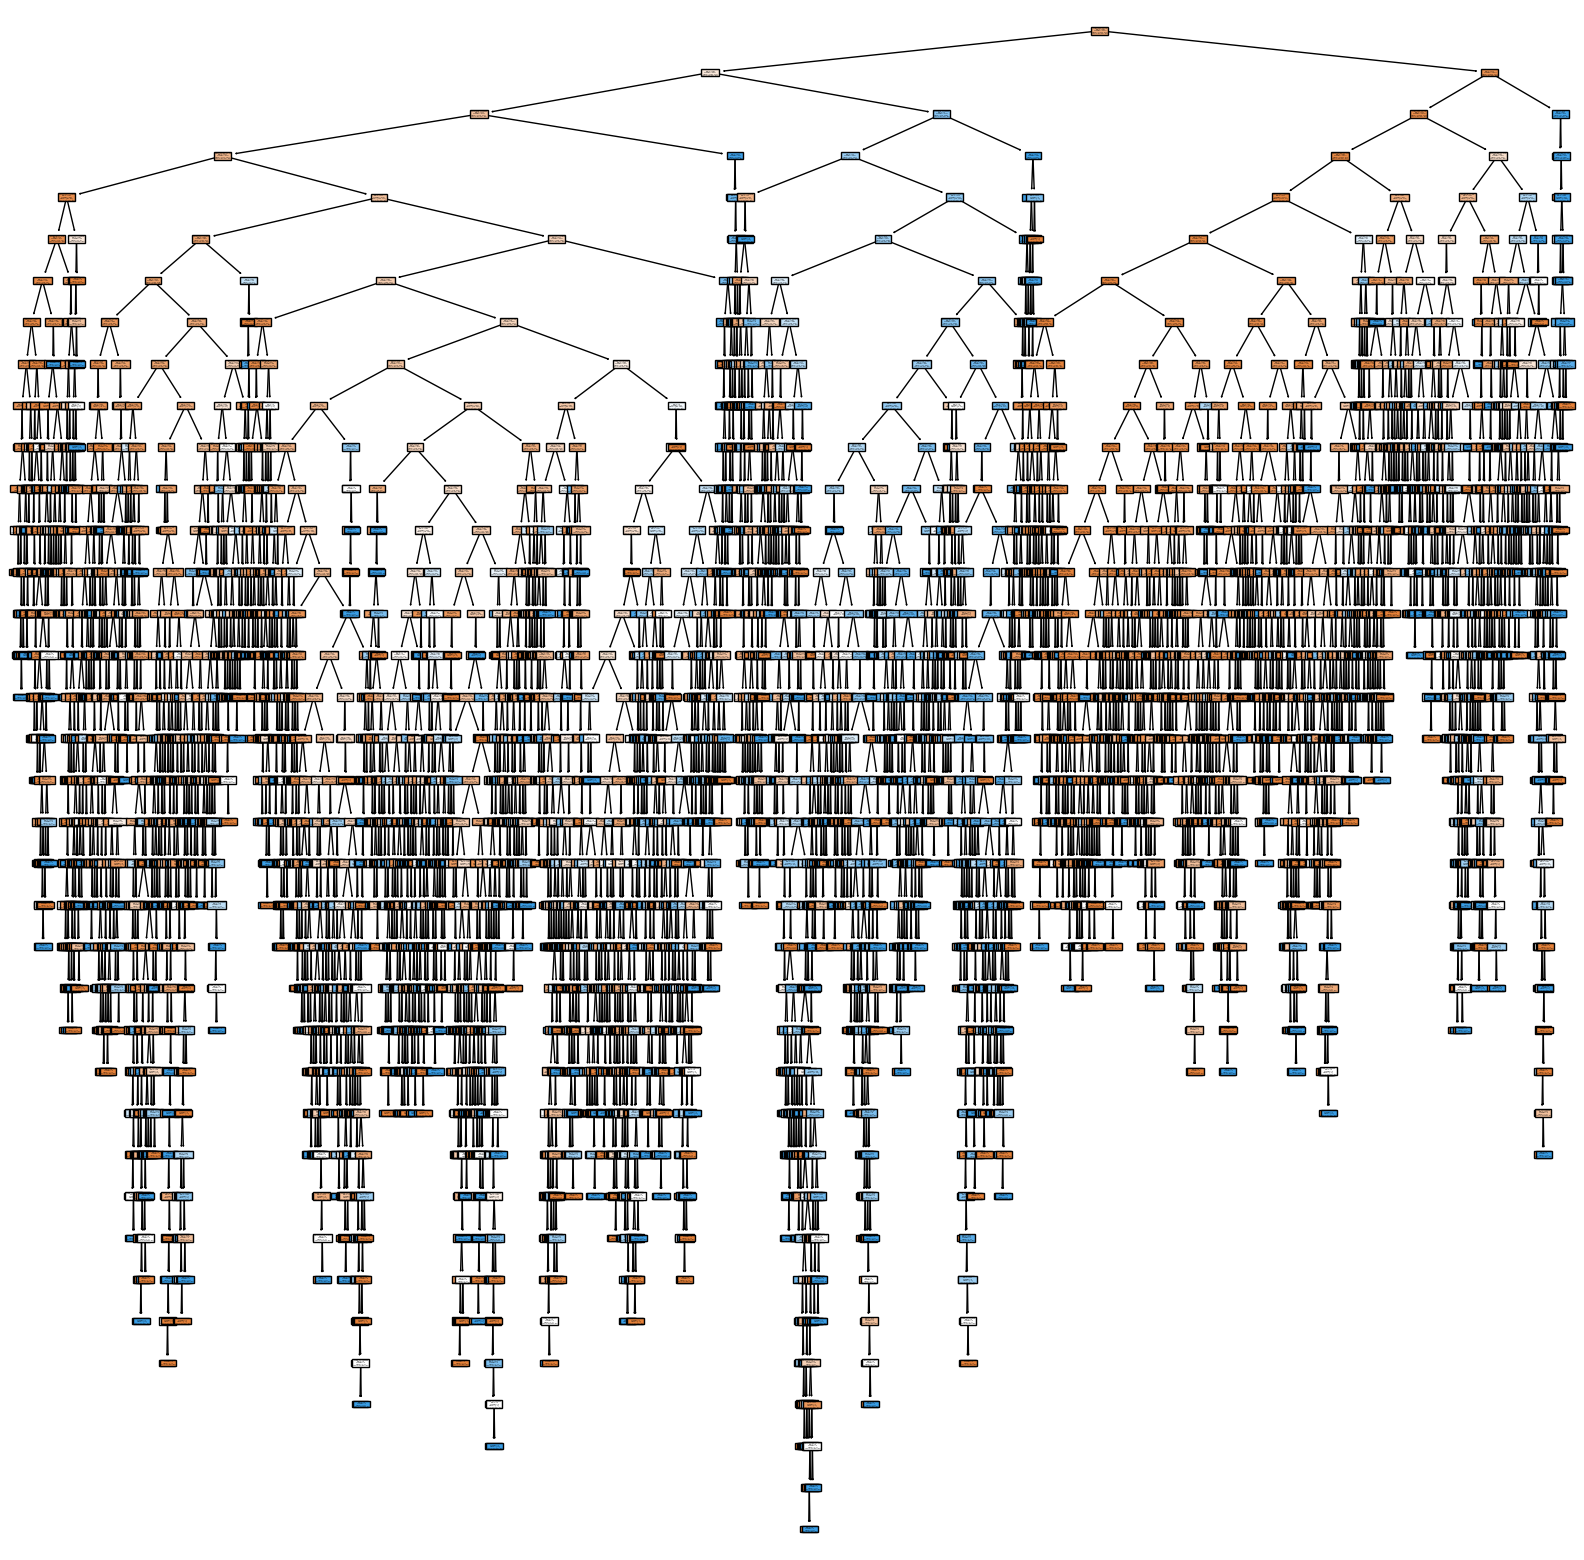

In [74]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['income < 50k','income > 50k']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

In [75]:
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

Train score 1.0
Test score 0.8054048520831201
Train Confusion matrix


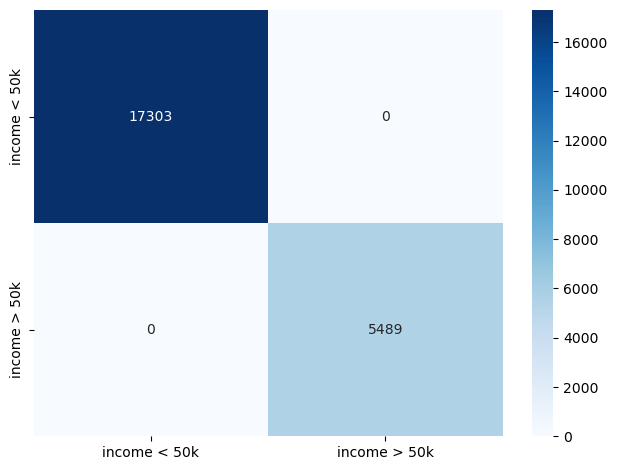

Test Confusion matrix


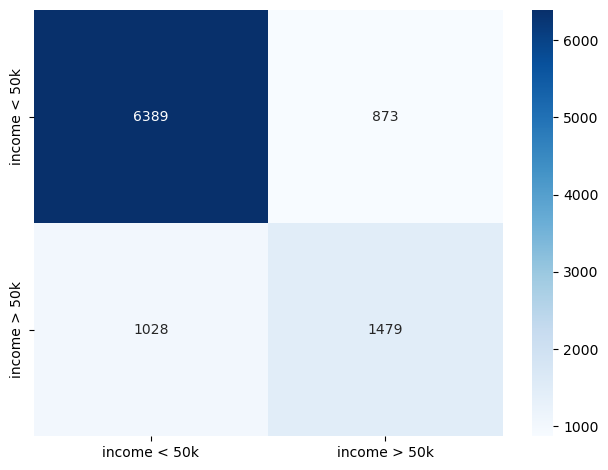

In [76]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

We can see that in our train data we have 100% accuracy (100 % precison and recall). But in 
test data model is not well generalizing. We have just 75% accuracy.
Over model is clearly overfitting. We will avoid overfitting through pruning. We will do cost complexity prunning

เราจะเห็นได้ว่าข้อมูลชุด traing มี Accuracy แทบจะ 100% แบบนี้เกิด overfitting แน่นอน
ในส่วนของ test นั้น มี Accuracy 75%
ต่อเดี๋ยวลองทำ pre pruning ดูว่าจะแก้ไขปัญหา overfitting ได้หรือไม่

## 1. Pre pruning techniques

Pre pruning is nothing but stoping the growth of decision tree on an early stage. For that we can limit the growth of trees by setting constrains. We can limit parameters like *max_depth* , *min_samples* etc.

An effective way to do is that we can grid search those parameters and choose the optimum values that gives better performace on test data. 

**Pre-pruning**<br>
หมายถึงการตัดกิ่งต้นไม้การตัดสินใจในช่วงเริ่มต้น ในการทำแบบนั้น เราสามารถจำกัดการเจริญเติบโตของต้นไม้โดยกำหนดเงื่อนไขได้ เช่น max_depth, min_samples เป็นต้น

วิธีที่มีประสิทธิภาพในการทำคือใช้การค้นหาแบบกริด (grid search) ในการปรับพารามิเตอร์เหล่านี้และเลือกค่าที่เหมาะสมที่สุดที่ให้ประสิทธิภาพที่ดีกว่าบนข้อมูลทดสอบ(Training set)

**Grid Search**<br>
หรือการค้นหาแบบกริด เป็นเทคนิคที่ใช้ในการหาค่า Hyperparameter ที่เข้าใจง่ายและตรงไปตรงมา ด้วยการลองใช้พารามิเตอร์ที่กำหนดไว้ล่วงหน้าทุกชุด และประเมินประสิทธิภาพหรือความแม่นยำของโมเดลแต่ละชุด จะเป็นการลองสร้างโมเดลจากค่าของ Hyperparameter ทุกชุด รูปแบบของการทำงานจะคล้ายกริด โดยค่าทั้งหมดจะอยู่ในรูปของเมทริกซ์ (Matrix) พารามิเตอร์แต่ละชุดจะถูกนำมาพิจารณาและสังเกตความถูกต้อง เมื่อชุดของ Hyperparameter ทั้งหมดได้รับการประเมินแล้ว โมเดลที่มีชุดพารามิเตอร์ที่ให้ความแม่นยำสูงสุดจะถือว่าดีที่สุด

As of now we will control these parameters
* max_depth: maximum depth of decision tree
* min_sample_split: The minimum number of samples required to split an internal node:
* min_samples_leaf: The minimum number of samples required to be at a leaf node.

In [77]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

Best: 0.854028 using {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 3}
Train score 0.8633292383292384
Test score 0.8506500153546934
Train Confusion matrix


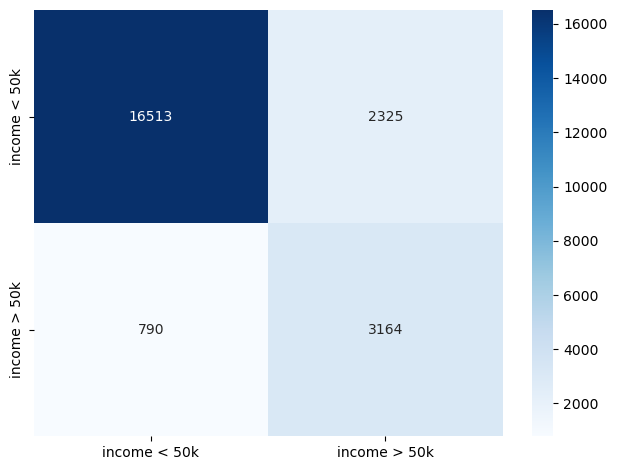

Test Confusion matrix


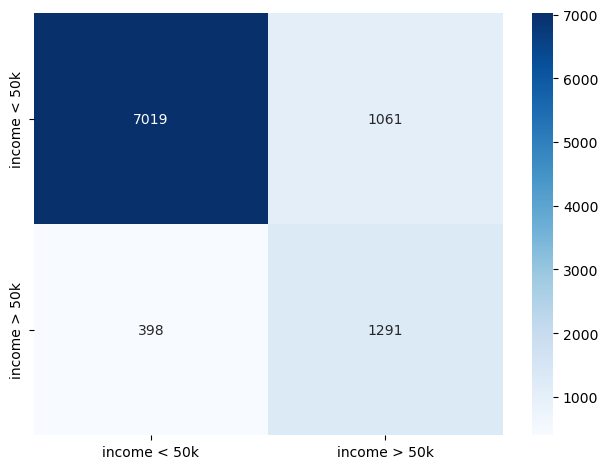

In [78]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train) #เรียนรู้แล้วทำนาย มีชุดข้อมูลเฉลยในตัว
y_test_pred = model.predict(x_test) #ลองทำนายจริงโดยไม่มีชุดข้อมูลเฉลย

print("Best: %f using %s" % (gcv.best_score_, gcv.best_params_))
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

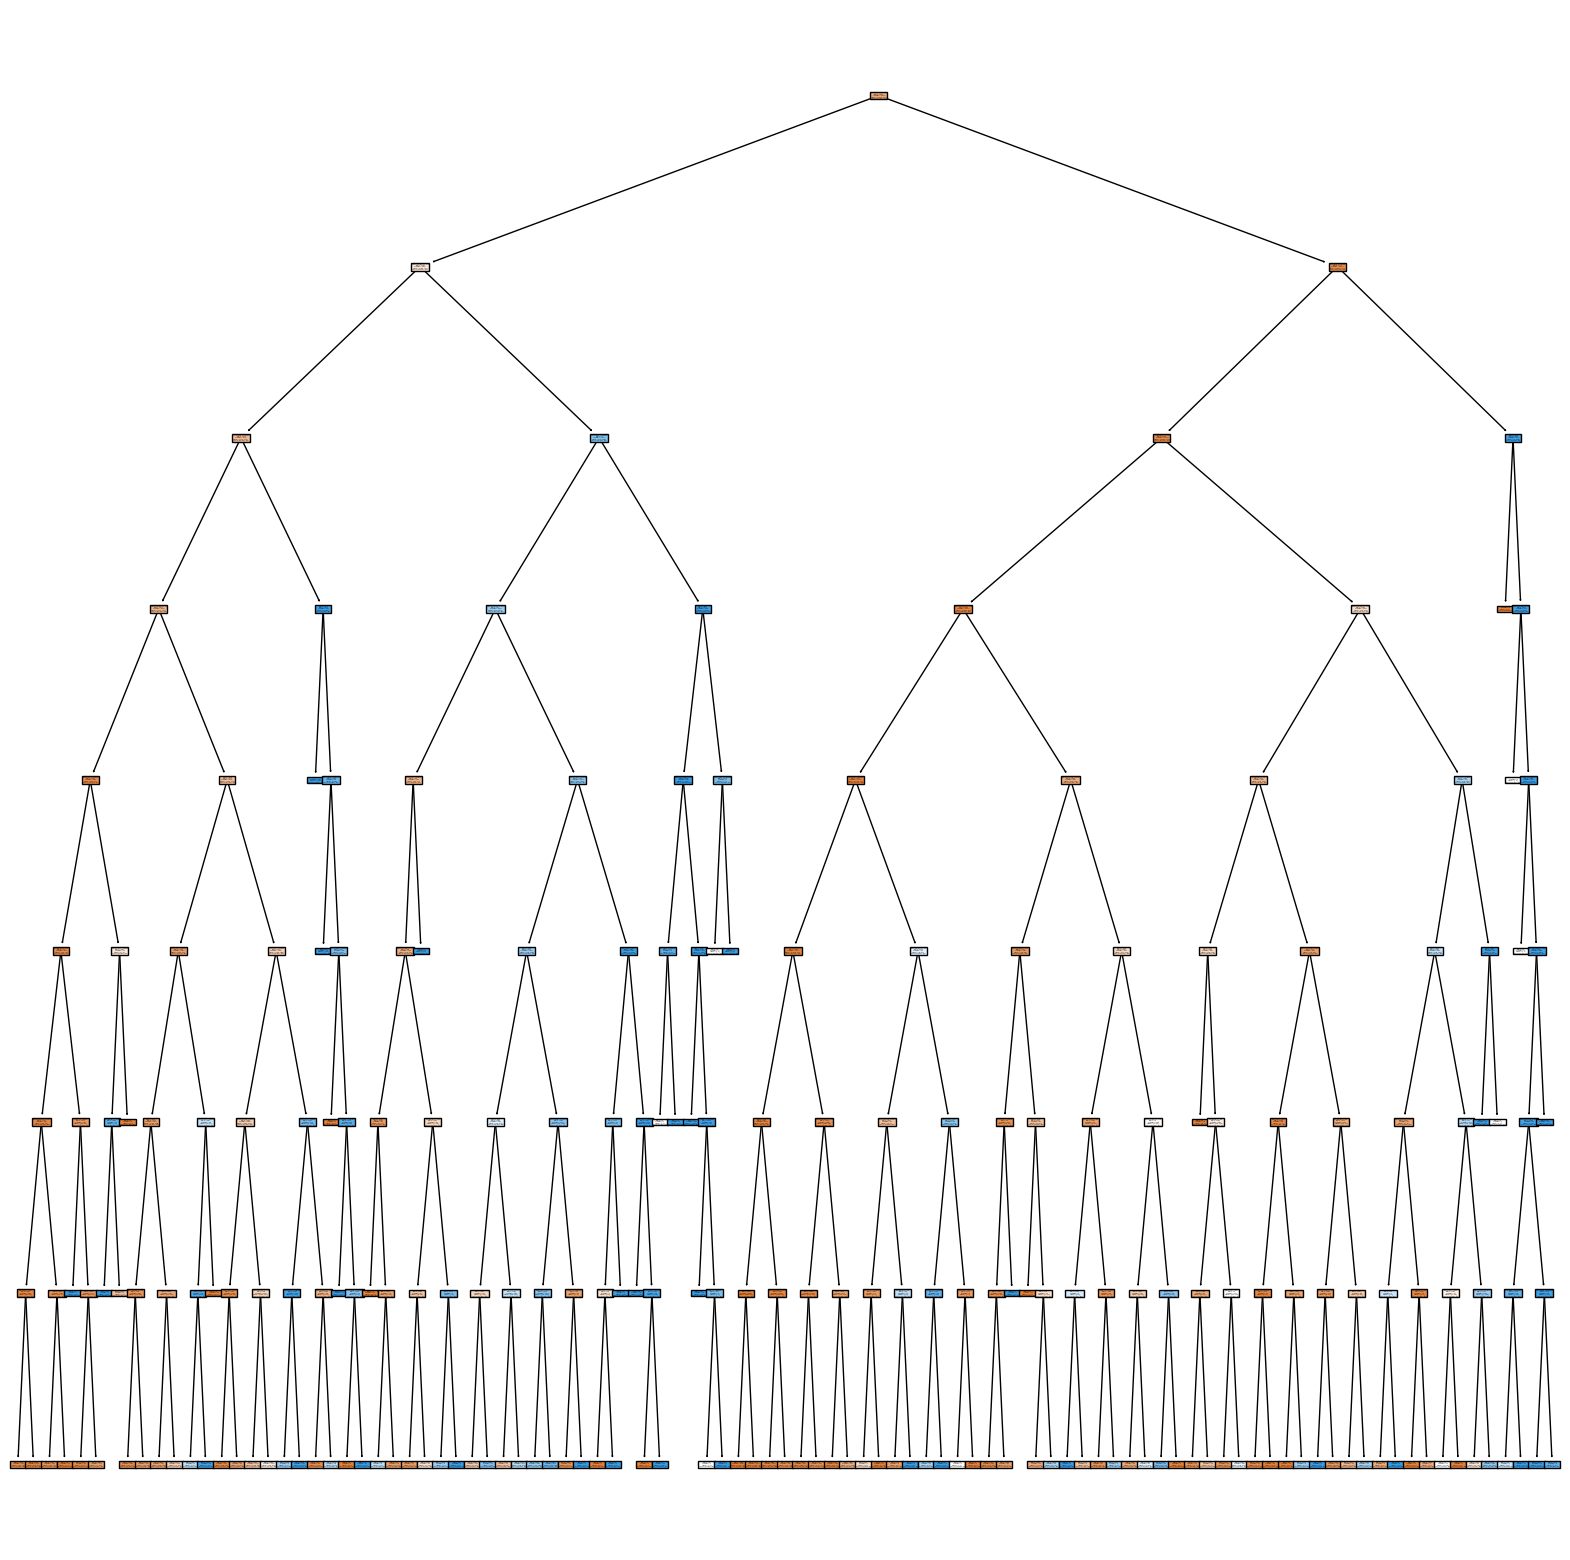

In [79]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['income < 50k','income > 50k']
tree.plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()

We can see that tree is pruned and there is improvement in test accuracy.But still there is still scope of improvement.
การตัดสร้างต้นไม้ (pruning) ได้ถูกทำและมีการปรับปรุงในความแม่นยำของชุดทดสอบ (test accuracy) อย่างไรก็ตามยังคงมีโอกาสในการปรับปรุงเพิ่มเติม


**หลังจากทำ Pre-pruning จะพบว่า**<br>
Train score 0.8632414882414883 -> accuracy 86.32%
Test score 0.8527996724332071 -> accuracy 85.28%
เห็นได้ว่า overfitting นั้นมีขนาดค่อนข้างที่จะแคบลงพอสมควร

**ในส่วนของ Grid search เราจะพบว่า**<br>
Best: 0.854115 using {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2 เป็นค่า param ที่อาจจะดีที่สุดในการกำหนดเงื่อนไขการ fit model โดยให้ค่า accuracy อยู่ที่ 85.41%

## 2. Post pruning techniques

There are several post pruning techniques. Cost complexity pruning is one of the important among them.
**Post pruning** <br>
เป็นการตัดกิ่งของต้นไม้หลัง training model แล้ว

## Cost Complexity Pruning


Decision trees can easily overfit. One way to avoid it is to limit the growth of trees by setting constrains. We can limit parameters like *max_depth* , *min_samples* etc. But a most effective way is to use post pruning methods like cost complexity pruning. This helps to improve test accuracy and get a better model.

เป็นวิธีการที่สามารถช่วยลดความซับซ้อนของต้นไม้การตัดสินใจและป้องกันการเรียนรู้เกินไปจากข้อมูล Training ทำให้โมเดลที่ได้มีประสิทธิภาพที่ดีและสามารถนำไปใช้งานได้อย่างมีประสิทธิภาพ

คล้ายๆ Pre-pruning เพียงแค่เรามาตัดแต่งทีหลัง -> parameters like *max_depth* , *min_samples*

Cost complexity pruning is all about finding the right parameter for **alpha**.We will get the alpha values for this tree and will check the accuracy with the pruned trees.

การทำ Cost complexity pruning นั้นเริ่มต้นด้วยการประเมินความซับซ้อนของต้นไม้แต่ละระดับของการตัดสินใจ โดยใช้ตัวแปรที่เรียกว่า cost complexity parameter (α) ซึ่งเป็นตัวบอกความสำคัญระหว่างความซับซ้อนของต้นไม้และความแม่นยำของโมเดล

ด้วยการปรับค่า cost complexity parameter (α) และการวัดประสิทธิภาพของต้นไม้ที่ผ่านการตัดสินใจ (pruned tree) โดยใช้ข้อมูลทดสอบ กระบวนการ Cost complexity pruning จะเลือกต้นไม้ที่มีค่า cost complexity parameter ที่น้อยที่สุดที่ยังคงให้ประสิทธิภาพที่ดีกับข้อมูลทดสอบ


To know more about cost complexity pruning watch [this vedio from Josh Starmer.](https://www.youtube.com/watch?v=D0efHEJsfHo&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=41)


In [80]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.00000000e+00 1.73359929e-05 1.74467822e-05 ... 2.12768874e-02
 2.63118854e-02 5.87965065e-02]


In [81]:
# For each alpha we will append our model to a list
# Loop ccp_alphas ทีละตัว แล้วเอาไป training model
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

In [82]:
clfs

[DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(ccp_alpha=1.7335992945749077e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=1.744678215266451e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.0940361849452768e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.1450021450021466e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.1571896571896583e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.189347068865118e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.4088259382377034e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.4375024375024375e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.507145364288222e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.6000026000025997e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.6000026000025997e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.6325026325026333e-05, random_state=0),
 DecisionTreeClassifier(ccp_alpha=2.6590935681844777e-05, rand

> 

We will remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.

เอา last element ใน clfs and ccp_alphas ออก เพราะ ต้นไม้มี node เดียว


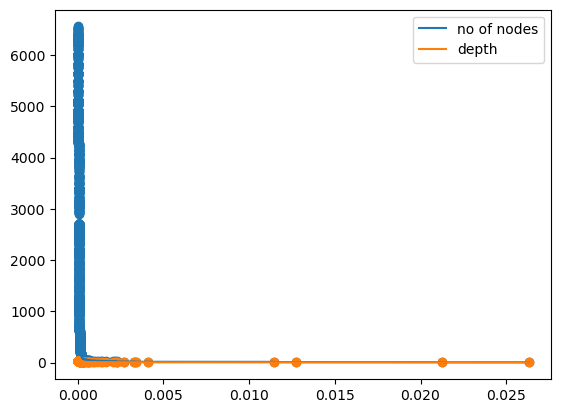

In [83]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

Observation: As alpha increases no of nodes and depth decreases

alpha เพิ่มขึ้น จำนวนของโหนดและความลึกของต้นไม้ลดลง (dataset ชุดนี้เห็นไม่ค่อยชัด)

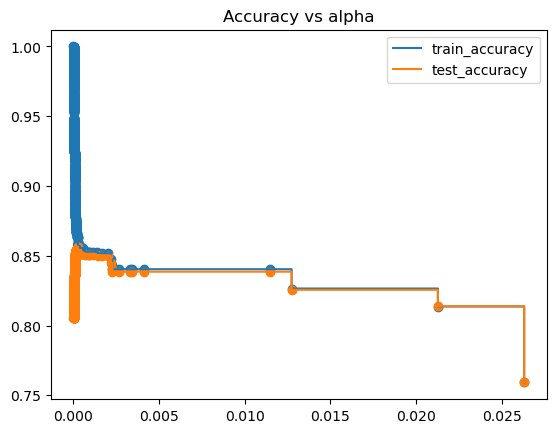

In [84]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

We can choose alpha = 0.006<br>
เข้าใจว่าช่วง 0.005 to 0.011 เราเลือกได้หมดเลยเพราะ space acc ค่อนข้างกว้างคงที่

Train score 0.8403387153387153
Test score 0.8385709898659024
Train Confusion matrix


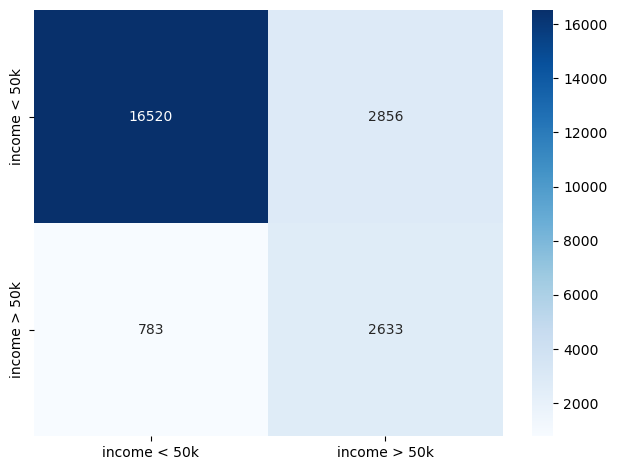

Test Confusion matrix


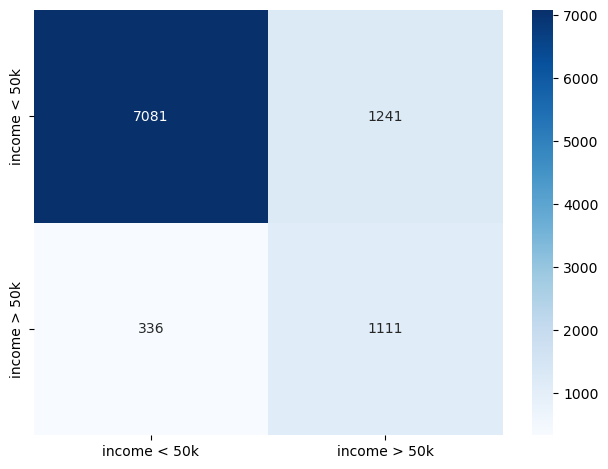

In [85]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.006)
clf_.fit(x_train,y_train)
y_train_pred = clf_.predict(x_train)
y_test_pred = clf_.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

We can see that now our model is not overfiting and performance on test data have improved

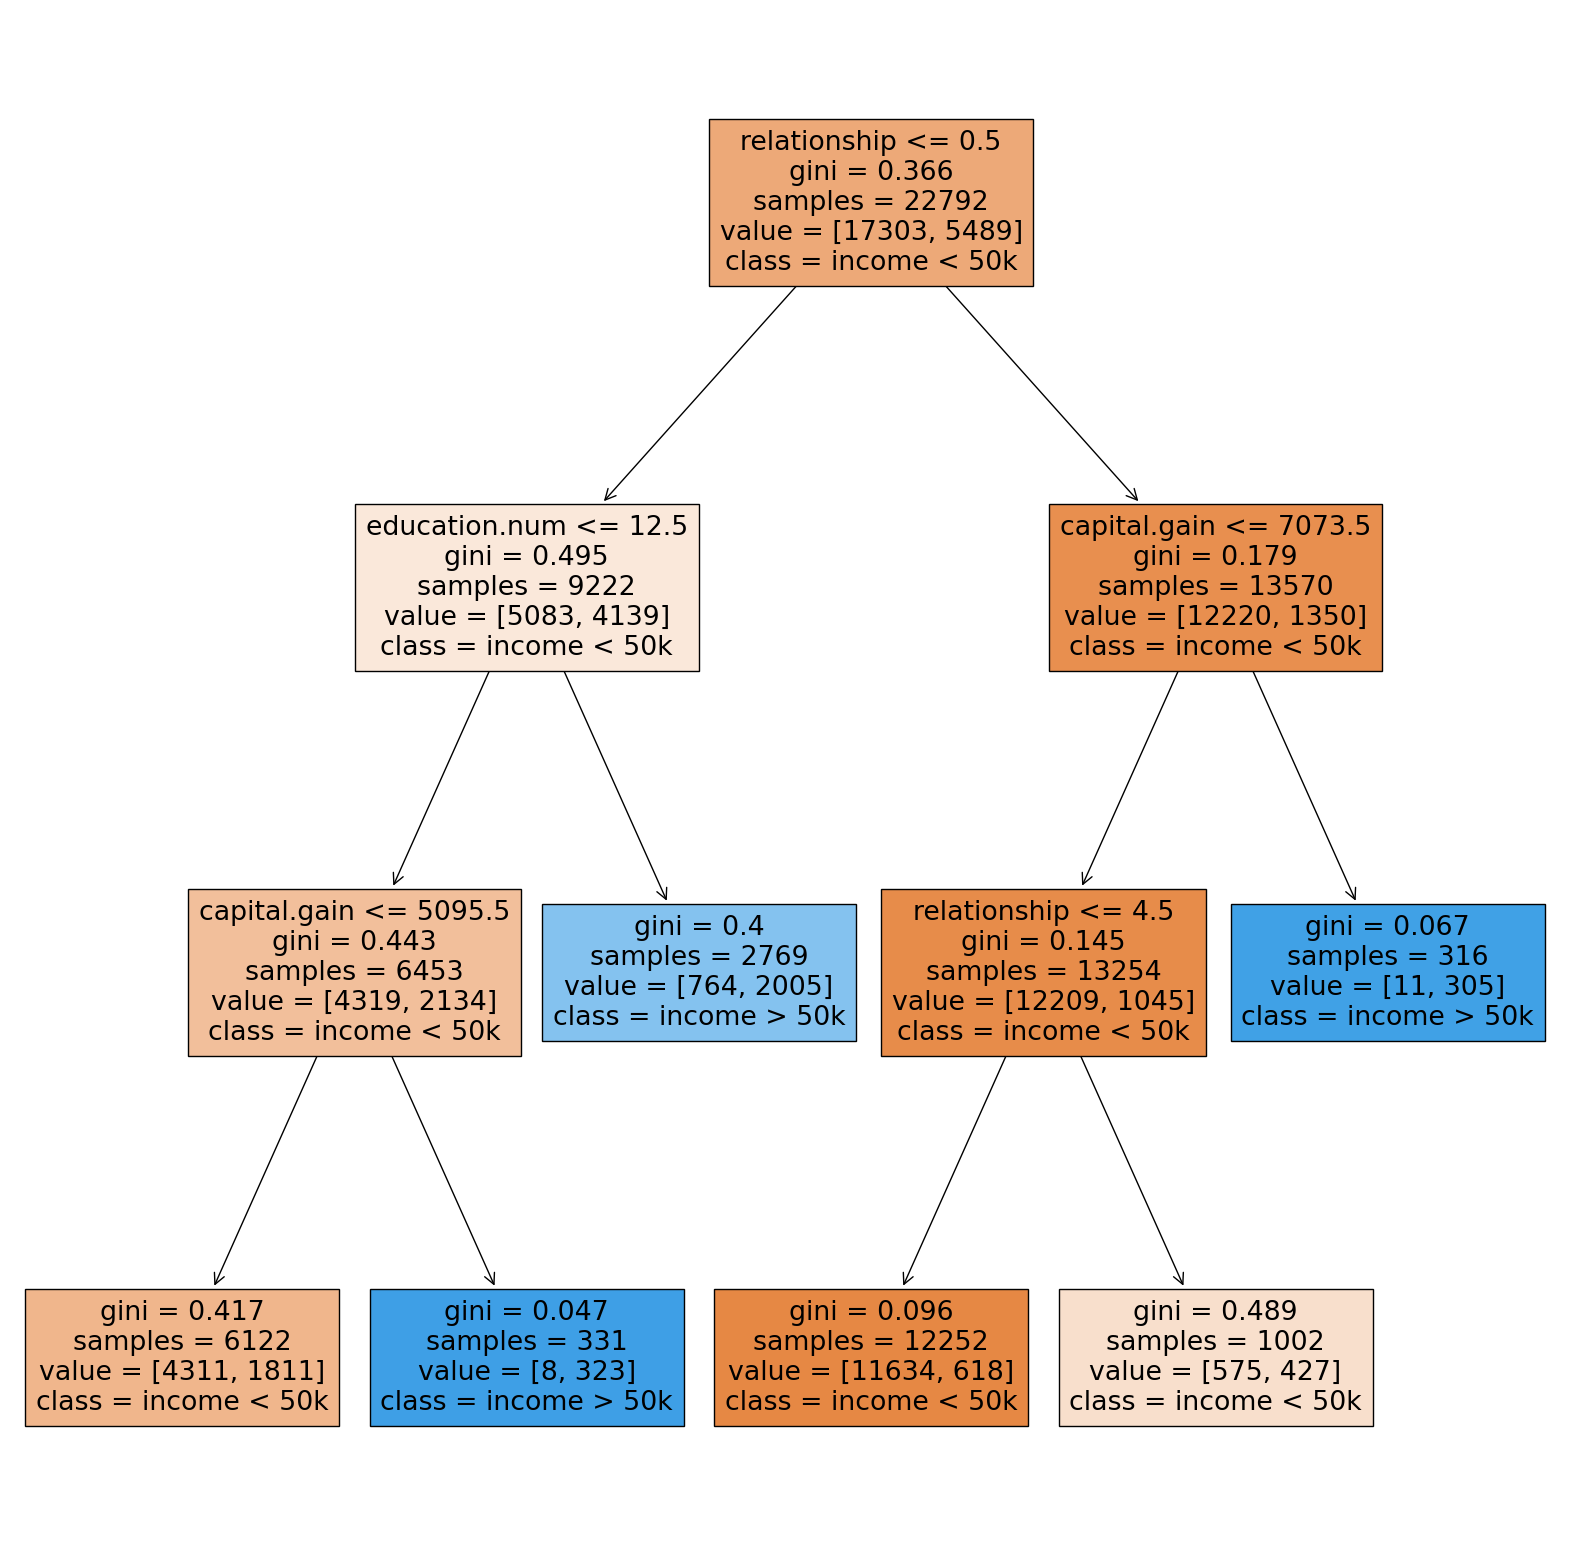

In [86]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['income < 50k','income > 50k']
tree.plot_tree(clf_,feature_names=features,class_names=classes,filled=True)
plt.show()

เราจะเห็นได้ว่าขนาดของต้นไม้เล็กลงอย่างมาก